# Calculate harmonics of the baroclinic surface velocity

In [34]:
#from soda.dataio.suntans.sunpy import Spatial
import xarray as xr
import dask
from netCDF4 import Dataset
import numpy as np
from scipy.interpolate import interp1d
from glob import glob
from datetime import datetime
import re

# from soda.dataio.suntans.sunxray import Sundask, Sunxray
from soda.utils.myproj import MyProj
from soda.utils.otherplot import axcolorbar
import soda.utils.harmonic_analysis as ha
from soda.utils.othertime import SecondsSince
from soda.utils.barycentric import BarycentricInterp
# from soda.dataio.suntans.suntans_ugrid import ugrid

import matplotlib.animation as animation
from IPython.display import HTML

from matplotlib import rcParams

#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "14"
rcParams['axes.labelsize']='large'

import matplotlib.pyplot as plt

In [81]:
!ls /scratch/pawsey0219/ijanekovic/ROMS_CYCLE/outputs

compress_precision_qck.sh  fwd2_6345.nc     mod_6345.nc  sta_6241.nc
compress_precision.sh	   fwd2_6349.nc     mod_6349.nc  sta_6253.nc
faillog_ver_6241.txt	   fwd2_6353.nc     mod_6353.nc  sta_6257.nc
fwd0_6241.nc		   fwd2_6357.nc     mod_6357.nc  sta_6261.nc
fwd0_6253.nc		   his_6241.nc	    obs_6289.nc  sta_6265.nc
fwd0_6269.nc		   log_6285.txt.gz  obs_6313.nc  sta_6269.nc
fwd0_6293.nc		   log_6293.txt.gz  obs_6317.nc  sta_6273.nc
fwd0_6317.nc		   log_6297.txt.gz  obs_6325.nc  sta_6277.nc
fwd0_6345.nc		   log_6301.txt.gz  obs_6329.nc  sta_6281.nc
fwd0_6349.nc		   log_6305.txt.gz  obs_6353.nc  sta_6285.nc
fwd0_6353.nc		   log_6309.txt.gz  obs_6357.nc  sta_6289.nc
fwd0_6357.nc		   log_6313.txt.gz  qck_6245.nc  sta_6293.nc
fwd1_6313.nc		   log_6317.txt.gz  qck_6257.nc  sta_6297.nc
fwd1_6317.nc		   log_6321.txt.gz  qck_6285.nc  sta_6301.nc
fwd1_6333.nc		   log_6325.txt.gz  qck_6289.nc  sta_6305.nc
fwd1_6337.nc		   log_6329.txt.gz  qck_6293.nc  sta_6309.nc
fwd1_6341.nc		   log_6333.txt.gz

In [82]:
step = 6317
# step += 4
basedir = '/scratch/pawsey0219/ijanekovic/ROMS_CYCLE/outputs/'
romsfile = '{}/qck_{}.nc'.format(basedir, step)

basedir = '/scratch/pawsey0219/ijanekovic/ROMS_CYCLE/outputs/verification'
romsverfile = '{}/qck_ver_{}.nc'.format(basedir, step)
#roms = xr.open_dataset(romsfile, chunks={})

roms = xr.open_dataset(romsfile).isel(ocean_time=range(24,96)) # No dask for a single file

# Load the verification run
romsver = xr.open_dataset(romsverfile).isel(ocean_time=range(24,96)) # No dask for a single file

print(roms.ocean_time[0].values, roms.ocean_time[-1].values,)
roms

2017-04-19T00:00:00.000000000 2017-04-21T23:00:00.000000000


<xarray.Dataset>
Dimensions:          (Nstate: 11, boundary: 4, eta_psi: 481, eta_rho: 482, eta_u: 482, eta_v: 481, ocean_time: 72, s_rho: 30, s_w: 31, tracer: 2, xi_psi: 1009, xi_rho: 1010, xi_u: 1009, xi_v: 1010)
Coordinates:
  * s_rho            (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w              (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.03333 0.0
    lon_rho          (eta_rho, xi_rho) float64 ...
    lat_rho          (eta_rho, xi_rho) float64 ...
    lon_u            (eta_u, xi_u) float64 ...
    lat_u            (eta_u, xi_u) float64 ...
    lon_v            (eta_v, xi_v) float64 ...
    lat_v            (eta_v, xi_v) float64 ...
    lon_psi          (eta_psi, xi_psi) float64 ...
    lat_psi          (eta_psi, xi_psi) float64 ...
  * ocean_time       (ocean_time) datetime64[ns] 2017-04-19 ... 2017-04-21T23...
Dimensions without coordinates: Nstate, boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    ntimes           int32 ...
    ndtfast          int32 ...
    dt               float64 ...
    dtfast           float64 ...
    dstart           datetime64[ns] ...
    nHIS             int32 ...
    ndefHIS          int32 ...
    nRST             int32 ...
    ntsAVG           int32 ...
    nAVG             int32 ...
    ndefAVG          int32 ...
    nADJ             int32 ...
    ndefADJ          int32 ...
    nTLM             int32 ...
    ndefTLM          int32 ...
    nOBC             int32 ...
    nSFF             int32 ...
    nSTA             int32 ...
    Nouter           int32 ...
    Ninner           int32 ...
    Falpha           float64 ...
    Fbeta            float64 ...
    Fgamma           float64 ...
    nl_tnu2          (tracer) float64 ...
    ad_tnu2          (tracer) float64 ...
    tl_tnu2          (tracer) float64 ...
    nl_visc2         float64 ...
    ad_visc2         float64 ...
    tl_visc2         float64 ...
    LuvSponge        int32 ...
    LtracerSponge    (tracer) int32 ...
    Akt_bak          (tracer) float64 ...
    Akv_bak          float64 ...
    Akk_bak          float64 ...
    Akp_bak          float64 ...
    ad_Akt_fac       (tracer) float64 ...
    tl_Akt_fac       (tracer) float64 ...
    ad_Akv_fac       float64 ...
    tl_Akv_fac       float64 ...
    rdrg             float64 ...
    rdrg2            float64 ...
    Zob              float64 ...
    Zos              float64 ...
    Znudg            float64 ...
    M2nudg           float64 ...
    M3nudg           float64 ...
    Tnudg            (tracer) float64 ...
    rho0             float64 ...
    R0               float64 ...
    Tcoef            float64 ...
    Scoef            float64 ...
    gamma2           float64 ...
    LuvSrc           int32 ...
    LwSrc            int32 ...
    LtracerSrc       (tracer) int32 ...
    LsshCLM          int32 ...
    Lm2CLM           int32 ...
    Lm3CLM           int32 ...
    LtracerCLM       (tracer) int32 ...
    LnudgeM2CLM      int32 ...
    LnudgeM3CLM      int32 ...
    LnudgeTCLM       (tracer) int32 ...
    Lstflux          (tracer) int32 ...
    Lobc             (Nstate, boundary) int32 ...
    LhessianEV       int32 ...
    LhotStart        int32 ...
    Lprecond         int32 ...
    Lritz            int32 ...
    GradErr          float64 ...
    HevecErr         float64 ...
    Nmethod          int32 ...
    Rscheme          int32 ...
    Nrandom          int32 ...
    Hgamma           float64 ...
    HgammaM          float64 ...
    HgammaB          float64 ...
    HgammaF          float64 ...
    Vgamma           float64 ...
    VgammaM          float64 ...
    VgammaB          float64 ...
    Hdecay           (Nstate) float64 ...
    Vdecay           (Nstate) float64 ...
    HdecayM          (Nstate) float64 ...
    VdecayM          (Nstate) float64 ...
    HdecayB          (boundary, Nstate) float64 ...
    VdecayB          (boundary, Nstate) float64 ...
    spherical        int32 ...
    xl        

In [83]:
xroms = roms.lon_rho.values
yroms = roms.lat_rho.values
h = roms.h.values

In [84]:
# Ripped out of SFODA: https://github.com/mrayson/sfoda/blob/master/sfoda/utils/timeseries.py#L1228
def ap2ep(u, v):
    """
    Convert u/v amplitude phase information to tidal ellipses
    
    All angles are in radians
    
    Returns:
        SEMA, SEMI, INC, PHS, ECC
    
    Based on the MATLAB ap2ep function:
        https://www.mathworks.com/matlabcentral/fileexchange/347-tidalellipse/content/ap2ep.m
    """
    # Make complex amplitudes for u and v
    #u = uamp*np.exp(-1j*uphs)
    #v = vamp*np.exp(-1j*vphs)

    #Calculate complex radius of anticlockwise and clockwise circles:
    wp = (u+1j*v)/2.0     # for anticlockwise circles
    wm = np.conj(u-1j*v)/2.0  # for clockwise circles
    # and their amplitudes and angles
    Wp = np.abs(wp)
    Wm = np.abs(wm)
    THETAp = np.angle(wp)
    THETAm = np.angle(wm)
   
    # calculate ep-parameters (ellipse parameters)
    SEMA = Wp+Wm              # Semi  Major Axis, or maximum speed
    SEMI = Wp-Wm            # Semin Minor Axis, or minimum speed
    ECC = SEMI/SEMA          # Eccentricity

    PHA = (THETAm-THETAp)/2.0   # Phase angle, the time (in angle) when 
                               # the velocity reaches the maximum
    INC = (THETAm+THETAp)/2.0   # Inclination, the angle between the 
                               # semi major axis and x-axis (or u-axis).
                               
    return SEMA, SEMI, INC, PHA, ECC

def calc_ubc_ellipse(romsobj, frqnames=['K1','M2']):
    roms = romsobj
    # Calculate the baroclinic velocity
    u_bc = roms['u_sur_eastward'] - roms['ubar_eastward'] 
    v_bc = roms['v_sur_northward'] - roms['vbar_northward'] 
    
    # # Load the data into memory
    # u_bc = u_bc.compute()
    # v_bc = v_bc.compute()
    u_bc = u_bc.values
    v_bc = v_bc.values
    u_bc[np.isnan(u_bc)] = 0.
    v_bc[np.isnan(v_bc)] = 0.
    
    reftime = datetime(2000,1,1)
    # Do the harmonic fits
    frq, names = ha.getTideFreq(frqnames)

    time = SecondsSince(roms['ocean_time'].values, basetime=reftime)
    na = 3 # Number of annual harmonics to include
    #aa, Aa, Ba,  = harmonic_fit_dask(u_bc, time, frq)
    Y  = ha.harmonic_fit_array(u_bc, time, frq)
    u0, u_re, u_im = Y[0,...], Y[1::2,...], Y[2::2,...]

    Y  = ha.harmonic_fit_array(v_bc, time, frq)
    v0, v_re, v_im = Y[0,...], Y[1::2,...], Y[2::2,...]
    
    #SEMA, SEMI, INC, PHS, ECC = ap2ep(u_re+1j*u_im, v_re+1j*v_im)
    
    return ap2ep(u_re+1j*u_im, v_re+1j*v_im)


In [85]:
#SEMA, SEMI, INC, PHS, ECC = ap2ep(u_re+1j*u_im, v_re+1j*v_im)
SEMA, SEMI, INC, PHS, ECC = calc_ubc_ellipse(roms)
SEMA_ver, SEMI_ver, INC_ver, PHS_ver, ECC_ver = calc_ubc_ellipse(romsver)

/home/mrayson/code/soda/soda/utils/harmonic_analysis.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,X)
/home/mrayson/group/mrayson/miniconda3/envs/soda/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/home/mrayson/group/mrayson/miniconda3/envs/soda/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/mrayson/code/soda/soda/utils/harmonic_analysis.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the o

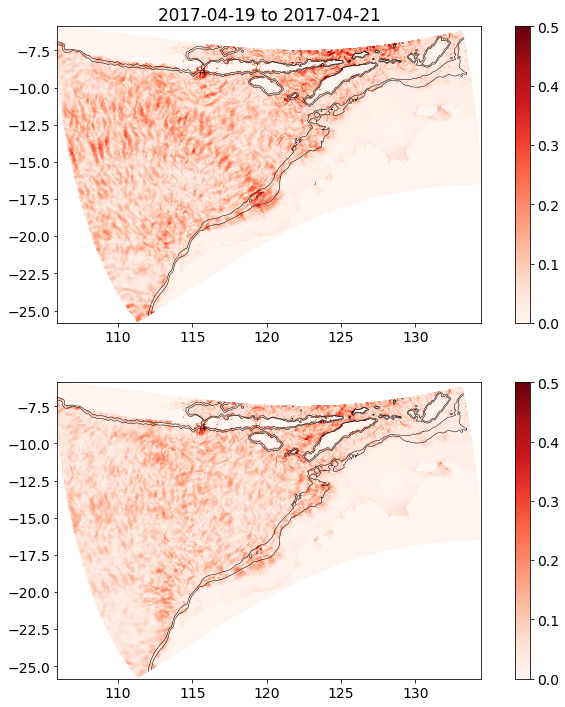

In [86]:
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.pcolormesh(xroms, yroms, SEMA[1,...], cmap='Reds', vmax=0.5)
plt.colorbar()
# plt.contour(xroms, yroms, PHS[1,...], [0], colors='k', linewidths=0.2)
plt.contour(xroms, yroms, h, [200,500], colors='k', linewidths=0.5)

plt.gca().set_aspect('equal')
plt.title(roms.ocean_time[0].values.astype(str)[0:10]+' to '+
         roms.ocean_time[-1].values.astype(str)[0:10])

plt.subplot(212)
plt.pcolormesh(xroms, yroms, SEMA_ver[1,...], cmap='Reds', vmax=0.5)
plt.colorbar()
# plt.contour(xroms, yroms, PHS[1,...], [0], colors='k', linewidths=0.2)
plt.contour(xroms, yroms, h, [200,500], colors='k', linewidths=0.5)

plt.gca().set_aspect('equal')
# plt.title(roms.ocean_time[0].values.astype(str)[0:10]+' to '+
#          roms.ocean_time[-1].values.astype(str)[0:10])


# plt.savefig('../FIGURES/ROMS_4DVAR_BC_Ellipse_{}.png'.format(roms.ocean_time[0].values.astype(str)[0:10]), dpi=150)

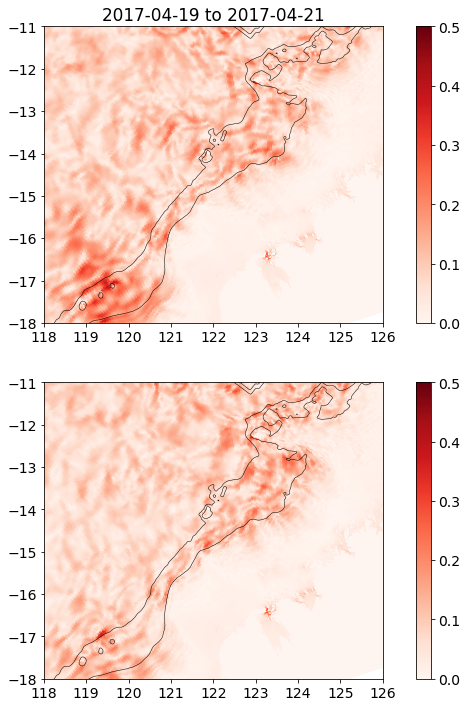

In [87]:
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.pcolormesh(xroms, yroms, SEMA[1,...], cmap='Reds', vmax=0.5)
plt.colorbar()
# plt.contour(xroms, yroms, PHS[1,...], [0], colors='k', linewidths=0.2)
plt.contour(xroms, yroms, h, [200,500], colors='k', linewidths=0.5)

plt.xlim(118,126)
plt.ylim(-18.0,-11.0)
plt.gca().set_aspect('equal')
plt.title(roms.ocean_time[0].values.astype(str)[0:10]+' to '+
         roms.ocean_time[-1].values.astype(str)[0:10])

plt.subplot(212)
plt.pcolormesh(xroms, yroms, SEMA_ver[1,...], cmap='Reds', vmax=0.5)
plt.colorbar()
# plt.contour(xroms, yroms, PHS[1,...], [0], colors='k', linewidths=0.2)
plt.contour(xroms, yroms, h, [200,500], colors='k', linewidths=0.5)
plt.xlim(118,126)
plt.ylim(-18.0,-11.0)
plt.gca().set_aspect('equal')

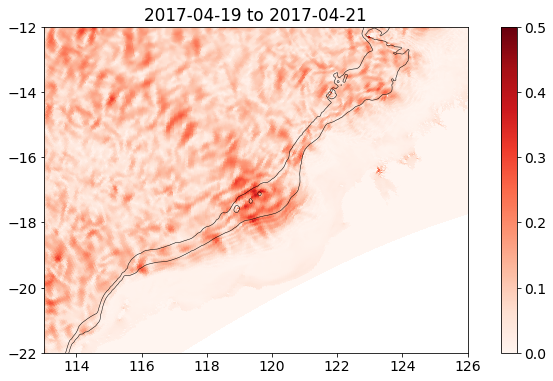

In [88]:
plt.figure(figsize=(12,6))
plt.pcolormesh(xroms, yroms, SEMA[1,...], cmap='Reds', vmax=0.5)
plt.colorbar()
#plt.contour(xroms, yroms, PHS[1,...], [0], colors='k', linewidths=0.2)
plt.contour(xroms, yroms, h, [200,500], colors='k', linewidths=0.5)

plt.title(roms.ocean_time[0].values.astype(str)[0:10]+' to '+
         roms.ocean_time[-1].values.astype(str)[0:10])

plt.xlim(113,126)
plt.ylim(-22.0,-12.0)
plt.gca().set_aspect('equal')
plt.savefig('../FIGURES/ROMS_4DVAR_BC_Ellipse_zoom_{}.png'.format(roms.ocean_time[0].values.astype(str)[0:10]), dpi=150)

In [89]:
## WEL Bathy Prelude transect
x0 = 122.753
y0 = -13.1026

x1 = 123.486+0.1
y1 = -13.947-0.1

# Prelude point
xpt = 123.3506
ypt = -13.7641

dx = 0.01 # ~1km

lon = np.arange(x0, x1, dx)
Fx = interp1d([x0,x1],[y0,y1])
lat = Fx(lon)

In [90]:
Fb = BarycentricInterp(np.array([xroms.ravel(), yroms.ravel()]).T, np.array([lon,lat]).T)

SEMA_line_M2 = Fb(SEMA[1,...].ravel())
SEMA_ver_line_M2 = Fb(SEMA_ver[1,...].ravel())

SEMA_line_K1 = Fb(SEMA[0,...].ravel())
SEMA_ver_line_K1 = Fb(SEMA_ver[0,...].ravel())

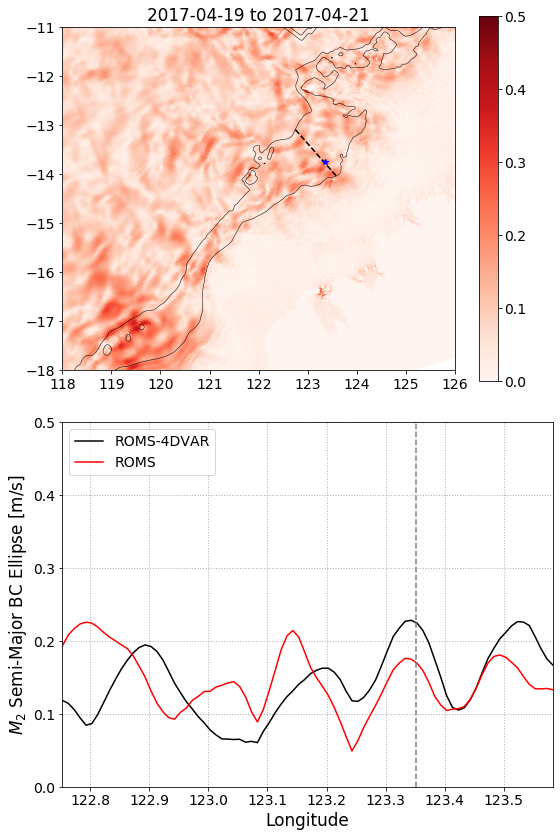

In [91]:
plt.figure(figsize=(8,12))
plt.subplot(211)
plt.pcolormesh(xroms, yroms, SEMA[1,...], cmap='Reds', vmax=0.5)
plt.colorbar()
# plt.contour(xroms, yroms, PHS[1,...], [0], colors='k', linewidths=0.2)
plt.contour(xroms, yroms, h, [200,500], colors='k', linewidths=0.5)

plt.xlim(118,126)
plt.ylim(-18.0,-11.0)
plt.gca().set_aspect('equal')
plt.title(roms.ocean_time[0].values.astype(str)[0:10]+' to '+
         roms.ocean_time[-1].values.astype(str)[0:10])

plt.plot(lon,lat,'k--')
plt.plot(xpt, ypt, 'b*')

plt.subplot(212)
plt.plot(lon, SEMA_line_M2,'k')
plt.plot(lon, SEMA_ver_line_M2,'r')

# plt.plot(lon, SEMA_line_K1,'k:')
# plt.plot(lon, SEMA_ver_line_K1,'r:')
plt.legend(('ROMS-4DVAR','ROMS'))

plt.plot([xpt,xpt],[0,0.5],'0.5', ls='--')
plt.ylim(0,0.5)
plt.xlim(lon[0], lon[-1])
plt.ylabel('$M_2$ Semi-Major BC Ellipse [m/s]')
plt.xlabel('Longitude')
plt.grid(b=True,ls=':',lw=1)

plt.tight_layout()

plt.savefig('../FIGURES/ROMS_4DVAR_BC_Ellipse_transect_{}.png'.format(roms.ocean_time[0].values.astype(str)[0:10]), dpi=150)